# First hyperparameter scan for these RQ-NSFs w/ the LU transformations

**Goal:** In the `First-NSF` notebook, I gained an understanding of *what* was involved in this choice of 25 seeds for trainins, but *now* I want to a quick hp scan to get an understanding for the various hyperparameters of interest here to find a reasonable setting for pressing forward. 

**What was varied (in a random search)**
- \# flow layers: (5, 10)
- \# of spline bins (knots - 1): (4,8)
- learning rate: (3e-4, 5e-4, 1e-3)
- dropout: (0 for no dropout, 0.1, 0.2)
- betas: (0,1e-6,1e-5,1e-4,1e-3)
- hidden dimension for the res net: (16, 32, 64)

In [42]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations
from glob import glob
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec

from utils import significance

import os
os.sys.path.append('../Flow-Models/')
from densityEstimate import *
from densityPlots import *

import os
os.sys.path.append('../code')
from eventDisplays import rainbow_text

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Load in the downsampled dataset.**

In [2]:
subDir = 'data16_PFlow-FEB20-5jets'
tag = '_SM_2b_p_0.01'
seedTag = ''
prodTag = 'FEB20'
ntag = 2

cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
d = data(5, 16, prodTag, tag, ntag, s)

mask = (d.df.abs_deta_hh < 1.5) 
d.mlPrepare(mask,cols,N=-1)

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


**For refs - hps used in my `First-NSF` notebook**

`
lr, beta = 1e-3,1e-3
L,H,nb = 5,32,2
K,B = 8,3
lt,bt = 'random','rq-coupling'
p = 0
`


Ok, I'll load in the different datasets for the 25 seeds, make the 10 predictions, but I think it might be judicious to save these histograms and error bars in a `.json` file so that I can load them in *faster* later when I rerun the notebook to iterate over the plots!!

**Goal:** Just print hps for the trainings that finished successfully.

In [3]:
colTag = '_'.join(cols)
wildFile = f'../Flow-Models/models/{subDir}{tag}_{ntag}b_detaCut/nsf_rq-coupling_{colTag}_lu_*_layers_H_*_?_blocks_K_?_B_3_lr_*_p*_iter*'

len(glob(wildFile))

90

In [4]:
nSeeds = 25
nPreds = 10

In [5]:
hpCols = ['L','H','num_blocks','K','lr','beta','p','iter']
hpCols += [f'{m} {s}' for s in range(nSeeds) for m in ['SR','val','train'] ]

hps = pd.DataFrame(0,index=range(len(glob(wildFile))), columns=hpCols)
hps.tail()

L  H  num_blocks  K  lr  beta  p  iter  SR 0  val 0  ...  train 21  SR 22  \
85  0  0           0  0   0     0  0     0     0      0  ...         0      0   
86  0  0           0  0   0     0  0     0     0      0  ...         0      0   
87  0  0           0  0   0     0  0     0     0      0  ...         0      0   
88  0  0           0  0   0     0  0     0     0      0  ...         0      0   
89  0  0           0  0   0     0  0     0     0      0  ...         0      0   

    val 22  train 22  SR 23  val 23  train 23  SR 24  val 24  train 24  
85       0         0      0       0         0      0       0         0  
86       0         0      0       0         0      0       0         0  
87       0         0      0       0         0      0       0         0  
88       0         0      0       0         0      0       0         0  
89       0         0      0       0         0      0       0         0  

[5 rows x 83 columns]

Also - these losses will be different for the **25** different random seeds as well!!

In [6]:
myVars = ['m_hh','m_hh_cor2','abs_deta_hh','absCosThetaStar',
          'pT_h1', 'pT_h2', 'eta_h1', 'eta_h2', 'dphi_hh']

bins = 50
myRanges = [(200,1200),(250,1250),(0,1.75),(0,1),
            (0,400),(0,400),(-3,3),(-3,3),(-.5,np.pi)]


(array([75416., 29181., 12681.,  6692.,  4065.,  2887.,  2166.,  1674.,
         1481.,  1425.]),
 array([4.71687072e-07, 3.14117037e-01, 6.28233602e-01, 9.42350168e-01,
        1.25646673e+00, 1.57058330e+00, 1.88469986e+00, 2.19881643e+00,
        2.51293299e+00, 2.82704956e+00, 3.14116613e+00]),
 <a list of 10 Patch objects>)

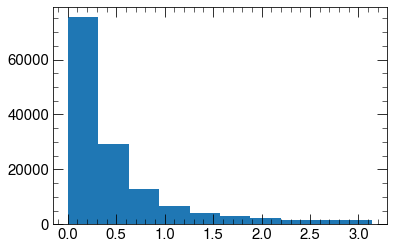

In [7]:
plt.hist(np.pi-d.df.dphi_hh)

File that was corrupted Nov $30^{th}$:

`../Flow-Models/models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut_seed7/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_5_layers_H_16_1_blocks_K_8_B_3_lr_0.0003_0.0001_p0.1_iter0/loss_acc.json doesn't exist`

In [9]:
reload = False

In [10]:
hists = []

for i,modelDir in tqdm(enumerate(glob(wildFile))):
    
    start = time()
    
    # Parse the file name for the relevant hps
    modelConfig = modelDir.split('/')[-1]
    vs = modelConfig.split('_')
    
    hps.loc[i,'L'] = int(vs[16])
    hps.loc[i,'H'] = int(vs[19])
    hps.loc[i,'num_blocks'] = int(vs[20])
    hps.loc[i,'K'] = int(vs[23])
   
    hps.loc[i,'lr'] = float(vs[27])
    hps.loc[i,'beta'] = float(vs[28]) if len(vs) == 31 else 0
    hps.loc[i,'p'] = float(vs[-2][1:])
    hps.loc[i,'iter'] = float(vs[-1][4:])
    
    # Loop over the seeds and access the losses and model predictions
    hist_list = {k:[] for k in myVars}
    
    for seed in range(nSeeds):
    
        seedTag = f'_seed{seed}' if seed != 10 else ''
        seedDir = os.path.join(*modelDir.split('/')[:-1]) + seedTag
        seedDir = os.path.join(seedDir,modelConfig)
    
        try:

            # Open json file
            try:
                with open(os.path.join(seedDir,'loss_acc.json'), 'r') as varfile:
                    metrics = json.load(varfile)

                    hps.loc[i,f'SR {seed}'] = metrics['SR_loss'][-22]
                    hps.loc[i,f'val {seed}'] = metrics['val_loss'][-22]
                    hps.loc[i,f'train {seed}'] = metrics['train_loss'][-22]
            except json.JSONDecodeError:
                print(os.path.join(seedDir,'loss_acc.json'),'is corrupted')
                    
                
            if reload:
                # Load in the models and get the predictions
                ni = myNSF(f'{subDir}{tag}_2b_detaCut{seedTag}', hps.loc[i,'lr'],hps.loc[i,'beta'],
                           cols, int(hps.loc[i,'iter']), hps.loc[i,'L'], hps.loc[i,'H'], 1, # num blocks
                           hps.loc[i,'K'], 3, 'lu', 'rq-coupling', hps.loc[i,'p'],
                           modelBaseDir='../Flow-Models/models', load_model=True,
                           torch_seed=seed, debug=False)

                # Predict
                npi = RealNVP_Plots(ni,save=False,mode=1)
                dfi = npi.pred_hh(d.X_SR,d.Y_SR,d.scalar,mask,d.df,nPreds=nPreds,cols=cols,plot=False)
                dfi['abs_deta_hh'] = np.abs(dfi.eta_h1 - dfi.eta_h2)
                
                # Make histograms
                for c,r in zip(myVars,myRanges):
                    hist_list[c].append(np.histogram(dfi[c],bins,r)[0] / nPreds)
            
        except FileNotFoundError:
            
            print(f'Model w/ seed {seed} didn\'t train in',modelConfig)
                
    # After looping through the seeds - if the training for all 25 of the seeds finished, let's
    # calc the mean and std deviation and *save* the result!!!
    histFile = os.path.join(modelDir,'hists1d.json')
    
    if reload:
        
        out = {}

        for c in myVars:
            stack = np.vstack(hist_list[c])
            out[f'{c}_mean'] = list(np.mean(stack,axis=0))
            out[f'{c}_std']  = list(np.std( stack,axis=0))

        with open(histFile, 'w') as varfile:
            json.dump(out, varfile)
        
    else:
        
        with open(histFile, 'r') as varfile:
            out = json.load(varfile)
             
    # Go from lists -> np.arrays and append to the hists
    for k in out.keys():
        out[k] = np.array(out[k])
        
    hists.append(out)
    
    end = time()
    dt = end - start
    if reload: print(f'Iter', i,':',dt//60,'min')

90it [01:05,  1.38it/s]


First metric, let's compare the losses!

In [11]:
ms = ['SR', 'val', 'train']

means = {}
stds  = {}

for m in ms:
    
    vals = hps[[f'{m} {s}' for s in range(nSeeds)]]
    
    means[m] = np.mean(vals[vals!=0], axis=1)
    stds[m]  = np.std(vals[vals!=0],  axis=1)


In [12]:
betaStr = r'$\beta$'

In [13]:
xlabels = []

for i, (L,H,nb,K,lr,beta,p) in hps[['L','H','num_blocks','K','lr','beta','p']].iterrows():

    xl = f'L={L:.0f}, H={H:.0f}, {nb:.0f} blocks, K={K:.0f}, lr={lr:.0e}, {betaStr}={beta:.0e}, p={p}'
    xlabels.append(xl)

In [14]:
figDir = f'figures/{subDir}{tag}_2b_detaCut/nsf_rq-coupling_{colTag}_lu_hpScan'
figDir

'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut/nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_hpScan'

In [15]:
text = "$\mathbf{ATLAS}$ data Internal\n"
text += "2016 data FEB2020 MNT prod\n"
text += "DL1r 77% WP, $\mathrm{\mathbb{P}}_{SM},|\Delta \eta_{hh}|$ < 1.5"

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


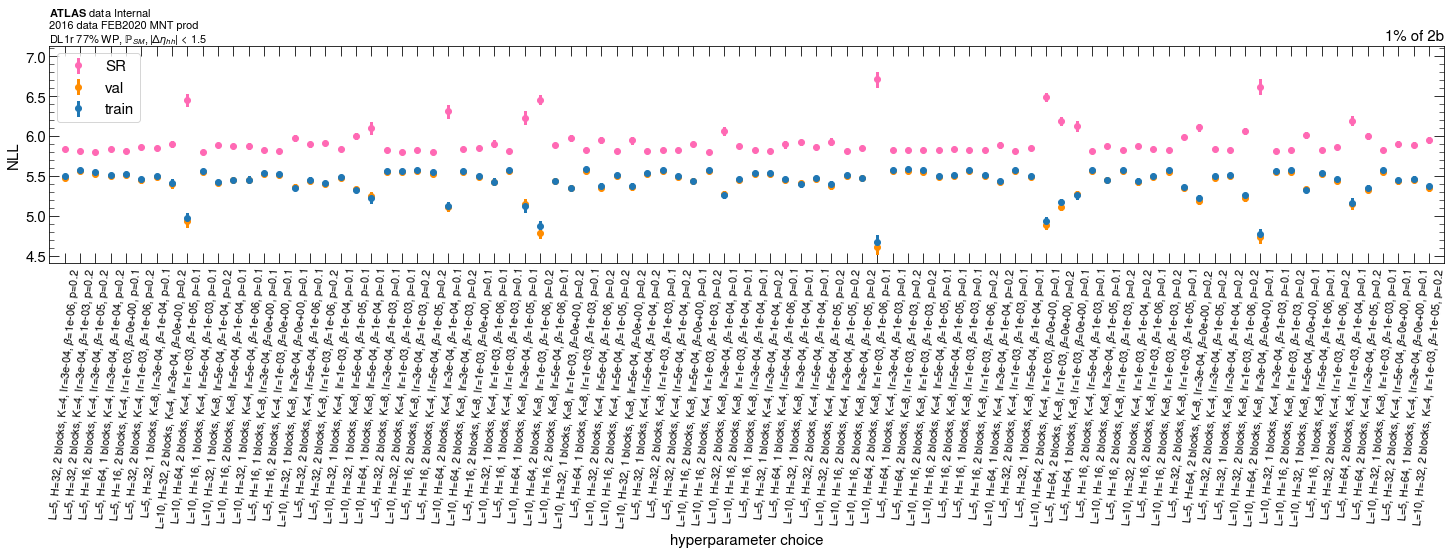

In [16]:
plt.figure(figsize=(25,4))

for m,c in zip(ms,['hotpink','darkorange','C0']):

    plt.errorbar(hps.index,means[m],stds[m],fmt='o',color=c,label=m)
    
    
plt.xticks(hps.index,xlabels,rotation=85,fontsize=11)
plt.xlabel('hyperparameter choice')
plt.ylabel('NLL')

ymin,ymax = plt.ylim()
plt.ylim(ymin,1.03*ymax)

plt.legend(fontsize=15,frameon=True,loc='upper left')
plt.title('1% of 2b',fontsize=15,loc='right')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)
ax.tick_params(axis='x',which='minor', length=0)

plt.xlim(-1,len(hps.index))

plt.savefig(f'{figDir}/loss_configs.pdf',bbox_inches='tight')
plt.show()

**Notes:**
- All these models have dropout!!
- i=2 is slightly better, w/ a smaller H and bigger $\beta$
- It still seems like higher $\beta$ slightly hurts the generalization performance
- This really bad model was at the edge of how large I was allowing my models to get: L=10, H=64, K=8, lr=3e-04, $\beta$=1e-05, p=0.1
- This other visual outlier was also on the edge of my model capacity: L=5, H=64, K=8, lr=1e-03, $\beta$=0e+00, p=0.1

In [17]:
for i, xl in enumerate(xlabels):
    print(i,xl)

0 L=5, H=32, 2 blocks, K=4, lr=3e-04, $\beta$=1e-06, p=0.2
1 L=5, H=32, 2 blocks, K=4, lr=3e-04, $\beta$=1e-03, p=0.2
2 L=5, H=16, 2 blocks, K=4, lr=3e-04, $\beta$=1e-05, p=0.2
3 L=5, H=64, 1 blocks, K=4, lr=3e-04, $\beta$=1e-04, p=0.2
4 L=5, H=16, 2 blocks, K=4, lr=1e-03, $\beta$=0e+00, p=0.1
5 L=5, H=32, 2 blocks, K=4, lr=1e-03, $\beta$=1e-06, p=0.2
6 L=5, H=32, 1 blocks, K=8, lr=3e-04, $\beta$=1e-04, p=0.1
7 L=10, H=32, 2 blocks, K=4, lr=3e-04, $\beta$=0e+00, p=0.2
8 L=10, H=64, 2 blocks, K=4, lr=1e-03, $\beta$=1e-05, p=0.1
9 L=10, H=16, 1 blocks, K=4, lr=5e-04, $\beta$=1e-03, p=0.1
10 L=10, H=32, 1 blocks, K=8, lr=5e-04, $\beta$=1e-04, p=0.2
11 L=10, H=16, 2 blocks, K=8, lr=5e-04, $\beta$=1e-04, p=0.1
12 L=10, H=32, 1 blocks, K=4, lr=5e-04, $\beta$=1e-06, p=0.1
13 L=5, H=16, 1 blocks, K=8, lr=3e-04, $\beta$=0e+00, p=0.1
14 L=5, H=16, 2 blocks, K=4, lr=1e-03, $\beta$=0e+00, p=0.1
15 L=10, H=32, 1 blocks, K=8, lr=3e-04, $\beta$=0e+00, p=0.1
16 L=5, H=32, 2 blocks, K=4, lr=5e-04, $\be

Understanding why I only saw 32 file directories...

**Plan:** Check how many files I have with the seed=0 flag.

In [18]:
for s in range(nSeeds):

    wildFile = f'../Flow-Models/models/{subDir}{tag}_{ntag}b_detaCut_seed{s}/nsf_rq-coupling_{colTag}_lu_*_layers_H_*_2_blocks_K_?_B_3_lr_*_p*_iter*'

    print(s,len(glob(wildFile)))

0 58
1 58
2 58
3 58
4 58
5 58
6 58
7 58
8 58
9 58
10 0
11 58
12 58
13 58
14 58
15 58
16 58
17 58
18 58
19 58
20 58
21 58
22 58
23 58
24 58


## Next: Let's look at $\chi^2$ agreement for some of the HH histograms

In [19]:
len(hists)

90

In [20]:
from scipy.stats import chisquare


In [21]:
mask = (d.df.kinematic_region==0)&(d.df.abs_deta_hh<1.5)

In [22]:
chi2 = {c: [] for c in myVars}

for i,hd in enumerate(hists):

    for c,r in zip(myVars,myRanges):

        # Get the 2b contribution
        n_2b = np.histogram(d.df.loc[mask,c],bins,r)[0]

        #print(chisquare(n_2b,hd[f'{c}_mean'])[0])
        chi2[c].append(chisquare(n_2b,hd[f'{c}_mean'])[0])
        #break
        
#     plt.figure()
#     e = np.linspace(*r,bins+1)
#     xx = 0.5*(e[:-1]+e[1:])
#     plt.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.')
#     plt.errorbar(xx,hd[f'{c}_mean'],hd[f'{c}_std'],fmt='.')
#     plt.title(f'i = {i}')
    
#     ax = plt.gca()
#     plt.text(.8,.8,f'$\chi^2$ = {chi2[c][-1]:.1f}',ha='right',va='top',transform=ax.transAxes)
#     plt.xlabel(c)
#     plt.ylabel('Entries')
    
    #break

In [23]:
np.sum(n_2b),np.sum(hd[f'{c}_mean'])

(10041, 10039.968000000003)

I must have some under/overflow, b/c if the predictions *by defn* are evaluating on the same events, they should be the same (I think)

**Next:** Let's compare the $\chi^2$ for the different hp configurations that I have!!

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


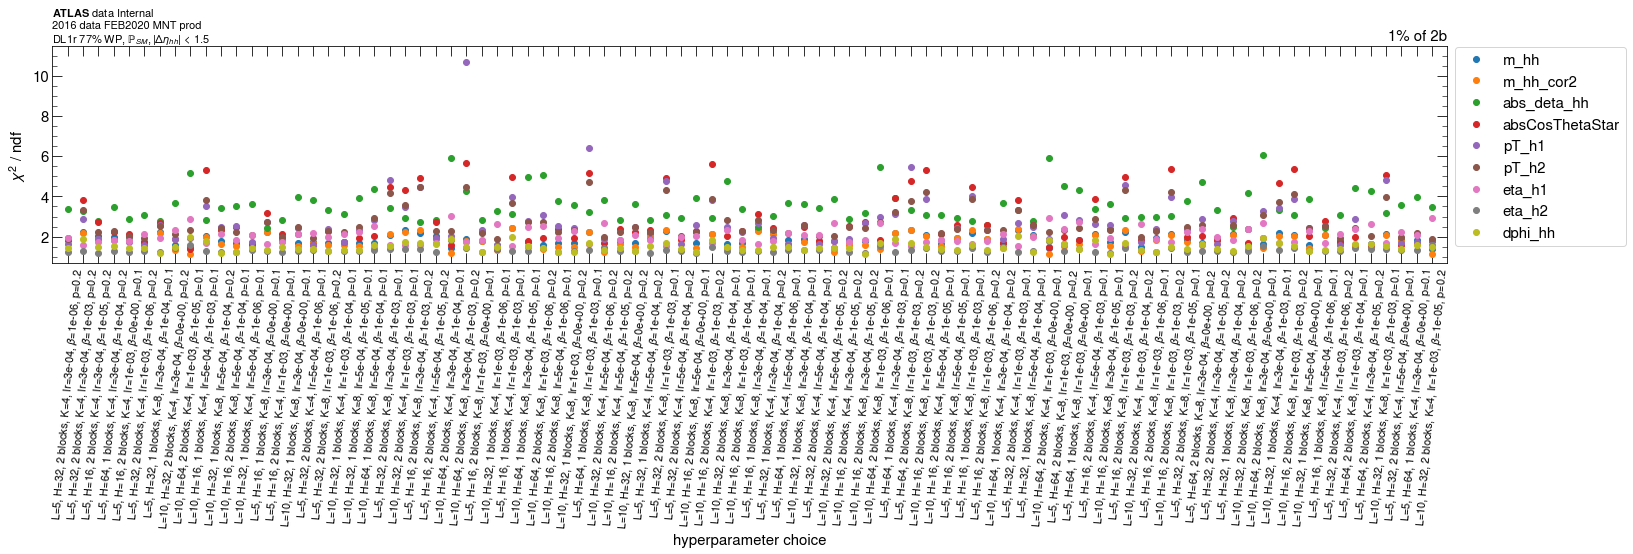

In [24]:
plt.figure(figsize=(25,4))

for c in myVars:

    plt.errorbar(hps.index,np.array(chi2[c])/bins,label=c,fmt='o')
    
plt.xticks(hps.index,xlabels,rotation=85,fontsize=11)
plt.xlabel('hyperparameter choice')
plt.ylabel(f'$\chi^2$ / ndf')

ymin,ymax = plt.ylim()
plt.ylim(ymin,1.03*ymax)

plt.legend(fontsize=15,frameon=True,bbox_to_anchor=(1,1.03))
plt.title('1% of 2b',fontsize=15,loc='right')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)
ax.tick_params(axis='x',which='minor', length=0)

plt.xlim(-1,len(hps.index))

plt.savefig(f'{figDir}/chi2ndf_allVars.pdf',bbox_inches='tight')
plt.show()

**Notes:**
- Both $m_{hh}$ and $m_{hh}^{cor,2}$ are mostly tracking w/ each other.
- The challenging variables seem to be $|\cos \Theta^*|$, $\Delta \eta_{hh}$, and $p_T^{h1,2}$

Let's look at a correlation plot of these variables!!

In [25]:
from scipy.stats import pearsonr

In [26]:
corr_mat = np.ones(tuple([len(myVars)]*2))

for i,ci in enumerate(myVars):
    for j,cj in zip(range(i+1,len(myVars)),myVars[i+1:]):

        Rij = pearsonr(np.array(chi2[ci]),np.array(chi2[cj]))[0]
        corr_mat[i,j] = Rij
        corr_mat[j,i] = Rij

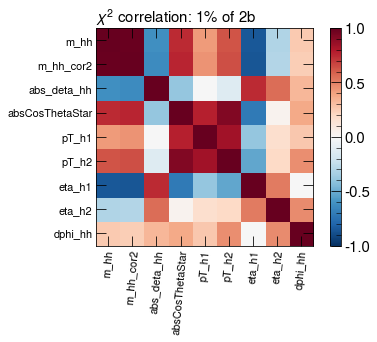

In [27]:
plt.imshow(corr_mat,cmap='RdBu_r',vmin=-1,vmax=1)

plt.colorbar()
plt.title('$\chi^2$ correlation: 1% of 2b',fontsize=15,loc='left')

# Label based on variable names
plt.xticks(range(len(myVars)),myVars,rotation=85,fontsize=11)
plt.yticks(range(len(myVars)),myVars,fontsize=11)

# Remove minor ticks
ax = plt.gca()
ax.tick_params(which='minor', length=0)

plt.savefig(f'{figDir}/chi2_correlation_allVars.pdf',bbox_inches='tight')

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


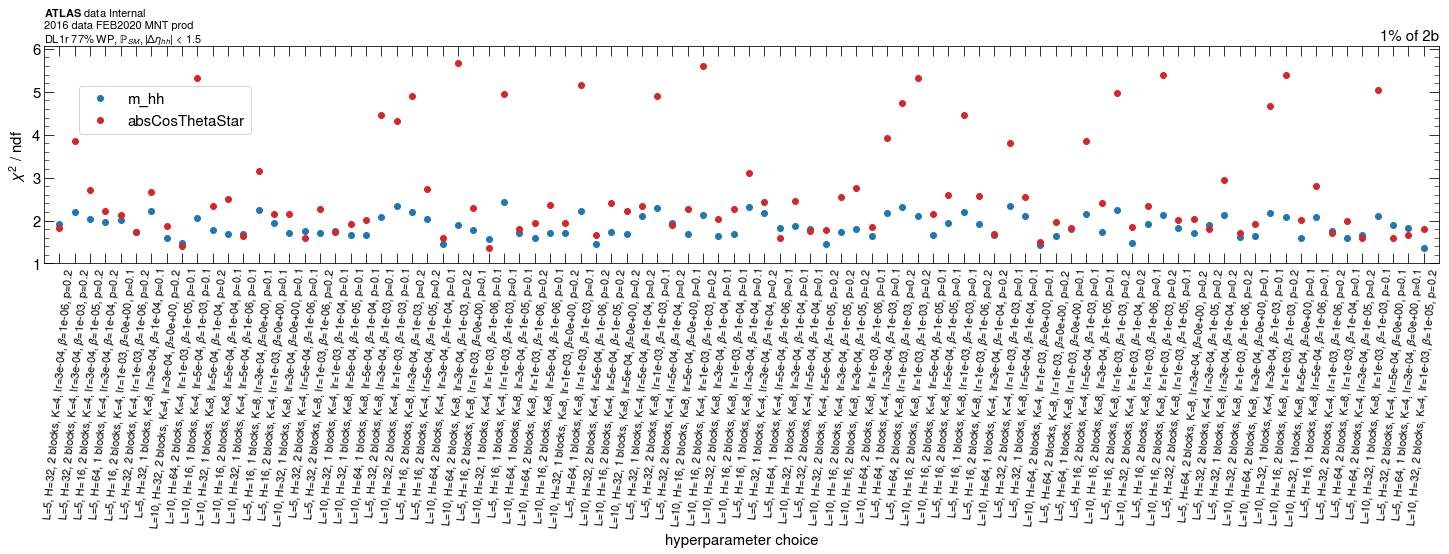

In [28]:
plt.figure(figsize=(25,4))

for c,color in zip(['m_hh','absCosThetaStar'],['C0','C3']):

    plt.errorbar(hps.index,np.array(chi2[c])/bins,label=c,fmt='o',color=color)
    
plt.xticks(hps.index,xlabels,rotation=85,fontsize=11)
plt.xlabel('hyperparameter choice')
plt.ylabel(f'$\chi^2$ / ndf')

ymin,ymax = plt.ylim()
plt.ylim(1,1.03*ymax)

plt.legend(fontsize=15,frameon=True,bbox_to_anchor=(0.02,.85),loc='upper left')
plt.title('1% of 2b',fontsize=15,loc='right')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)
ax.tick_params(axis='x',which='minor', length=0)

plt.xlim(-1,len(hps.index))

plt.savefig(f'{figDir}/chi2ndf_m_hh_absCosThetaStar.pdf',bbox_inches='tight')
plt.show()

## Scatter plots

I want to get an intuition for the correlation b/w the SR loss and the $\chi^2$ modelling for the variables that we care about. 

In [29]:
# means

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


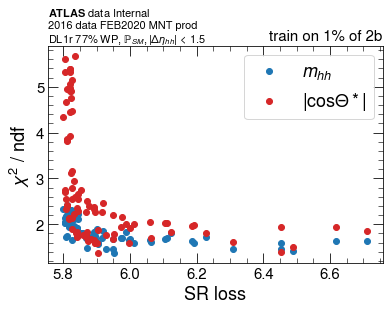

Substituting with a symbol from Computer Modern.


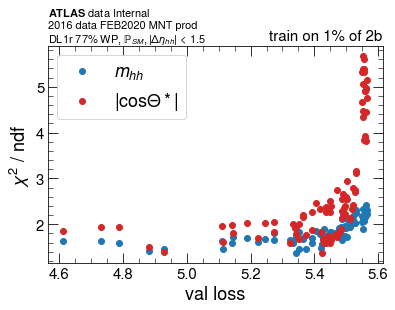

Substituting with a symbol from Computer Modern.


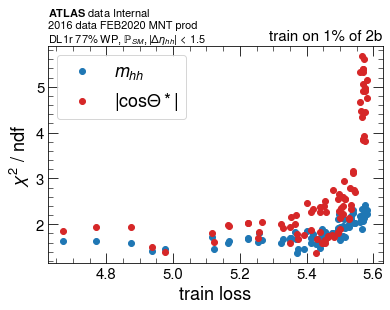

In [30]:
for m in ['SR','val','train']:

    plt.figure()
    for c,color,l in zip(['m_hh','absCosThetaStar'],['C0','C3'],['$m_{hh}$','$|\cos\Theta *|$']):
        plt.scatter(means[m],np.array(chi2[c])/bins,color=color,marker='o',label=l)

    plt.xlabel(f'{m} loss',fontsize=18)
    plt.ylabel('$\chi^2$ / ndf',fontsize=18)
    plt.legend(frameon=True,fontsize=18)


    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)

    plt.title('train on 1% of 2b',fontsize=15,loc='right')


    plt.savefig(f'{figDir}/chi2ndf_m_hh_absCosThetaStar_vs_{m}_loss.pdf',bbox_inches='tight')


Ok - this was counter-intuitive to me. For the training and validation region, the loss has a *positive* correlation with the modelling variables.

However for the SR loss, there's a *negative* correlation, which I think is saying that ...

I'm not 100% sure what negative correlation says, but I do know that rn the SR is *qualitatively* different than the training region for $|\cos\Theta^*|$, so maybe this is what the correlation loss is piciking up on??

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


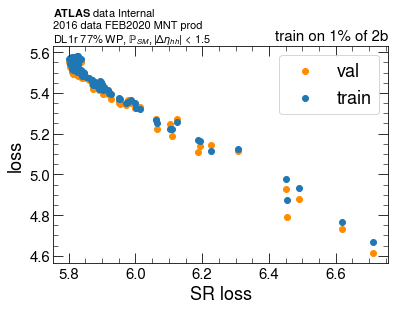

In [31]:
for m,color in zip(['val','train'],['darkorange','C0']):

    plt.scatter(means['SR'],means[m],color=color,marker='o',label=m)

plt.xlabel(f'SR loss',fontsize=18)
plt.ylabel(f'loss',fontsize=18)
plt.legend(frameon=True,fontsize=18)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=11)

plt.title('train on 1% of 2b',fontsize=15,loc='right')

plt.savefig(f'{figDir}/loss_scatter.pdf',bbox_inches='tight')



This is a little wierd, but all it's telling us is that we're overfitting to the distribution we're training on, so minimizing outside of the SR is *not* translating to better performance in the SR (at least for this set of hps)

**This is so interesting,** and I think it was the opposite of what I saw for the RealNVP models.

**Intuition building:** I'm interested in which hyperparameters correspond to better $m_{hh}$ modelling.

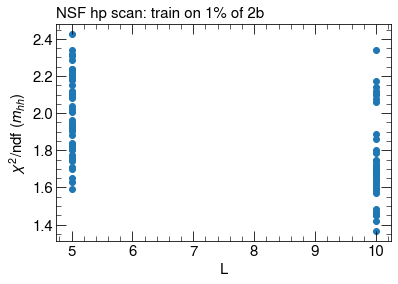

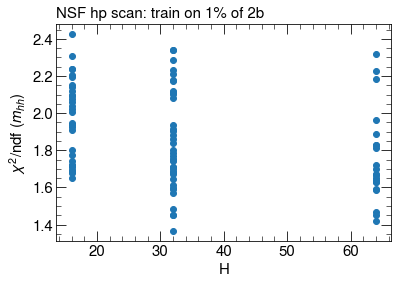

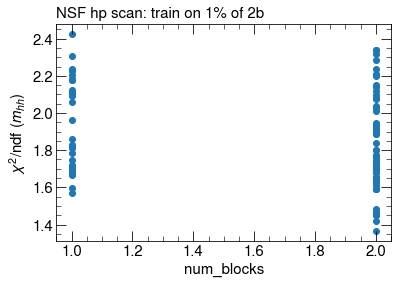

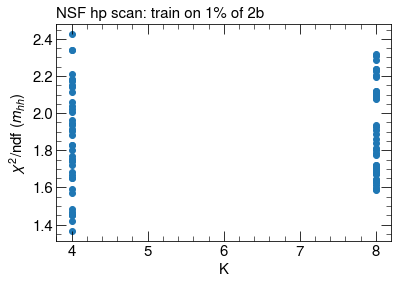

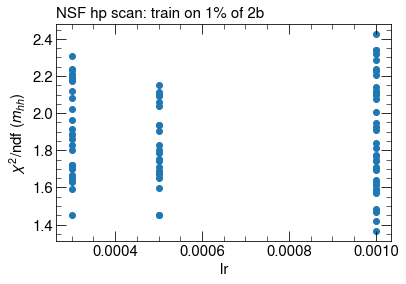

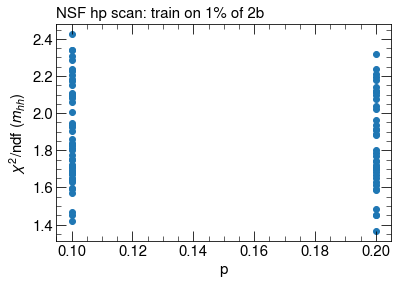

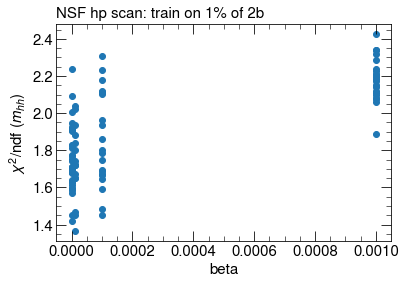

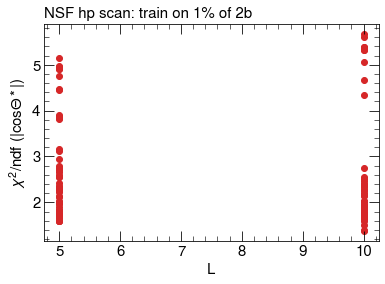

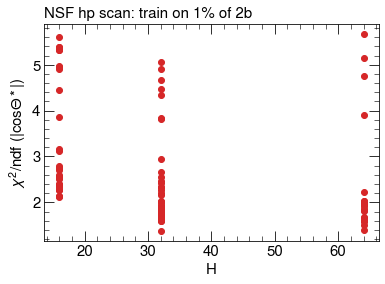

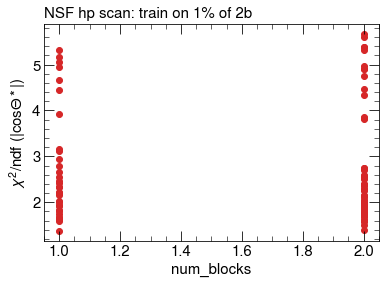

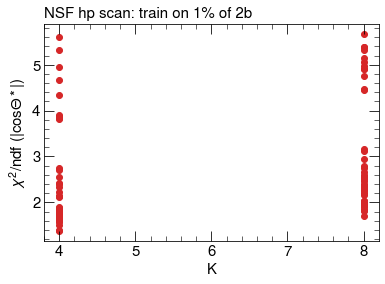

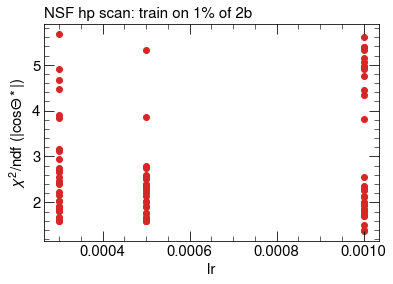

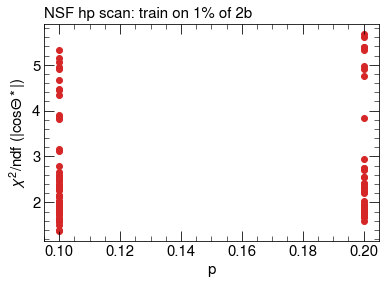

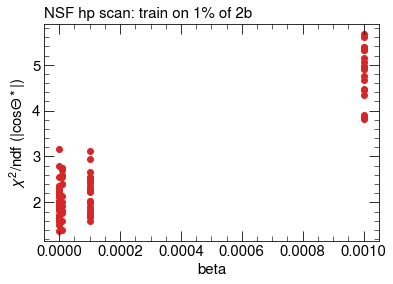

In [32]:
for c,color,l in zip(['m_hh','absCosThetaStar'],['C0','C3'],['$m_{hh}$','$|\cos\Theta *|$']):

    for hpi in ['L','H','num_blocks','K','lr','p','beta']:

        plt.figure()
        plt.scatter(hps[hpi],np.array(chi2[c])/bins,color=color)
        plt.xlabel(hpi)
        plt.ylabel(f'$\chi^2$/ndf ({l})')
        plt.title('NSF hp scan: train on 1% of 2b',fontsize=15,loc='left')
        plt.savefig(f'{figDir}/scatterPlots/chi2_{c}_vs_{hpi}.pdf',bbox_inches='tight')
    
plt.show()

**Notes:**
1. L = 10 seems preferred (as in it prefers to have *more* steps to implement these transformations
2. H = 32 seems the best
2. K does not seem to be a relevant hp.
3. lr of 5e-4 seems like a good compromise for these experiments
4. Prefers lower dropout
5. Now $\beta$ does not seem as relevant of a hp

**Hyperparameter proposal:** L=10, H=32, K=8, lr=5e-4,p=0.2,$\beta$=1e-6


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


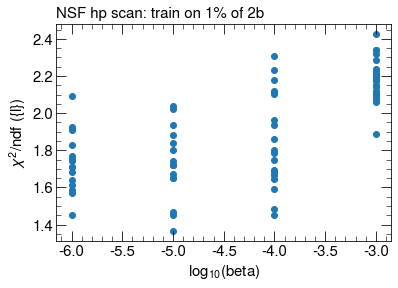

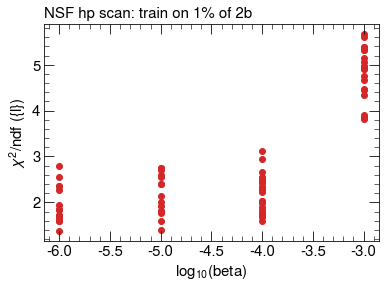

In [33]:
for c,color,l in zip(['m_hh','absCosThetaStar'],['C0','C3'],['$m_{hh}$','$|\cos\Theta *|$']):
    
    plt.figure()
    plt.scatter(np.log10(hps[hpi]),np.array(chi2[c])/bins,color=color)
    plt.xlabel('$\log_{10}$'+f'({hpi})')
    plt.ylabel('$\chi^2$/ndf ({l})')
    plt.title('NSF hp scan: train on 1% of 2b',fontsize=15,loc='left')
    plt.savefig(f'{figDir}/scatterPlots/chi2_{c}_vs_log_{hpi}.pdf',bbox_inches='tight')

plt.show()

## Top k comparson with different metrics 

So, I've been exploring the interplay b/w some of the various metrics that I can be considering / looking at, so it seems reasonable to break this down a bit with seeing what the overlap are b/w the top 5 (or 10) performing models for the metrics of
1. SR loss
2. $\chi^2$ for $m_{hh}$
2. $\chi^2$ for $|\cos \Theta^*|$

In [34]:
i_SR  = np.argsort(means['SR'].values)
i_mhh = np.argsort(np.array(chi2['m_hh']))
i_cts = np.argsort(np.array(chi2['absCosThetaStar']))

In [35]:
top_k = 10

In [36]:
i_SR[:top_k]

array([22, 42, 24,  9,  2, 79, 51, 38, 62, 67])

In [37]:
i_mhh[:top_k]

array([89, 64, 25, 50, 35,  8, 70, 28, 31, 84])

In [38]:
i_cts[:top_k]

array([28,  8, 64, 16, 47, 87, 85, 25, 12, 88])

- Not surprising that it doesn't seem like there's any overlap b/w the models w/ the lowest SR loss and the best $\chi^2$s for $m_{hh}$ and $|\cos\Theta^*|$.
- The configs for i = 8, i = 64, i=25, i = 28 are in the top 10 performing models for *both* $m_{hh}$ and $|\cos \Theta^*|$

In [39]:
hps.iloc[[8,25,28,64]]

L   H  num_blocks  K      lr      beta    p  iter      SR 0     val 0  \
8   10  64           2  4  0.0010  0.000010  0.1  39.0  6.517073  4.874633   
25  10  64           2  4  0.0003  0.000100  0.1  27.0  6.355650  5.110315   
28  10  32           1  4  0.0010  0.000001  0.1   0.0  5.976670  5.390613   
64  10  64           2  4  0.0010  0.000000  0.1  48.0  6.504802  4.855654   

    ...  train 21     SR 22    val 22  train 22     SR 23    val 23  train 23  \
8   ...  4.899140  6.312598  5.067710  5.099999  6.376792  5.011830  5.042679   
25  ...  5.151034  6.189631  5.197124  5.197448  6.241024  5.144883  5.152364   
28  ...  5.379754  5.896777  5.403813  5.400202  5.842639  5.462207  5.464567   
64  ...  4.974155  6.552295  4.823065  4.878482  6.467382  4.874323  4.935921   

       SR 24    val 24  train 24  
8   6.391579  4.986198  5.018355  
25  6.318463  5.073247  5.070196  
28  5.866276  5.472887  5.478733  
64  6.550967  4.833883  4.879328  

[4 rows x 83 columns]

Cool, cool, let's look at some plots now then!!

In [58]:
myVars

['m_hh',
 'm_hh_cor2',
 'abs_deta_hh',
 'absCosThetaStar',
 'pT_h1',
 'pT_h2',
 'eta_h1',
 'eta_h2',
 'dphi_hh']

In [64]:
varLabels = ['$m_{hh}$ [GeV]','$m_{hh}^{cor,2}$ [GeV]',
             '$|\Delta \eta_{hh}|$','$|\cos \Theta *|$',
             '$p_T^{h1}$','$p_T^{h2}$','$\eta_{h1}$','$\eta_{h2}$','$\Delta \Phi_{hh}$']

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

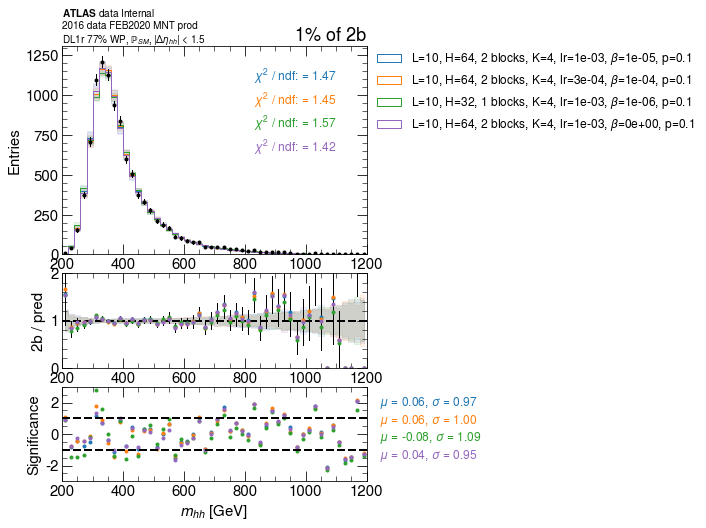

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


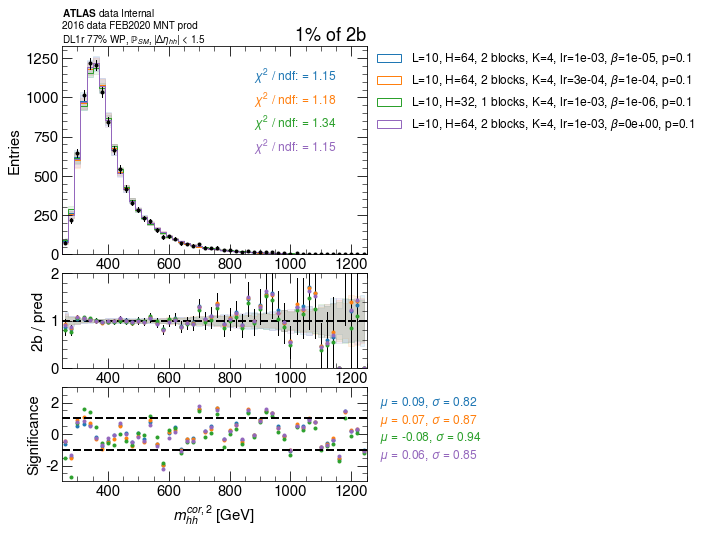

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


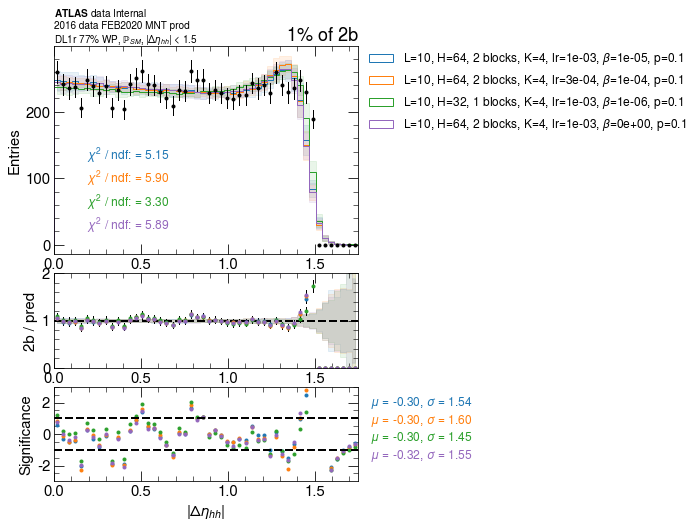

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


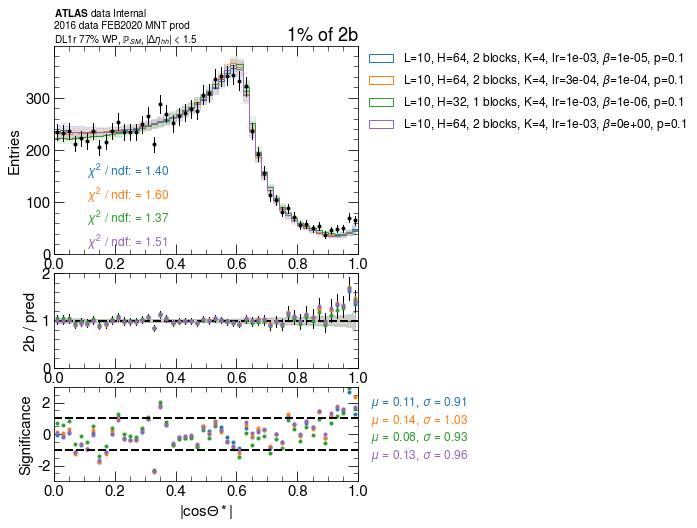

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


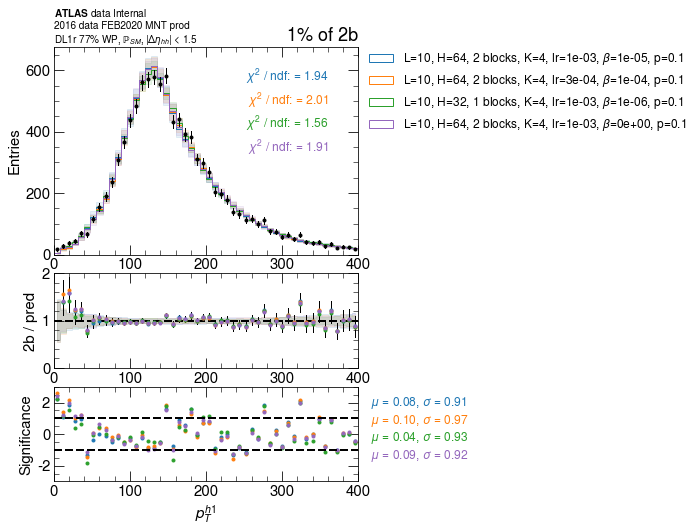

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


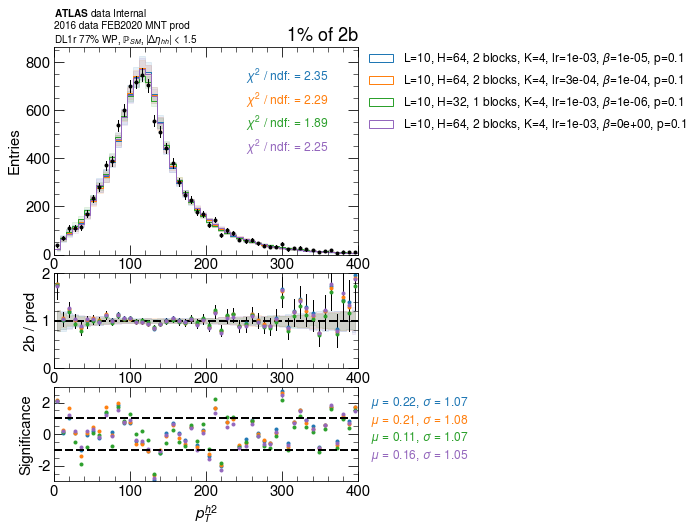

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


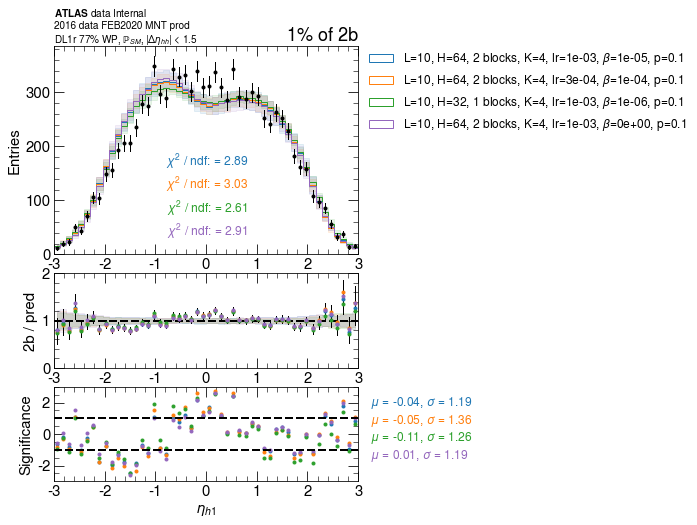

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


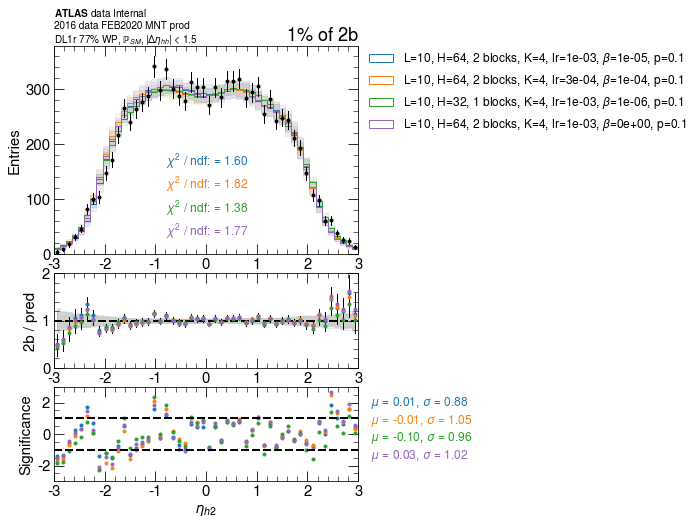

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


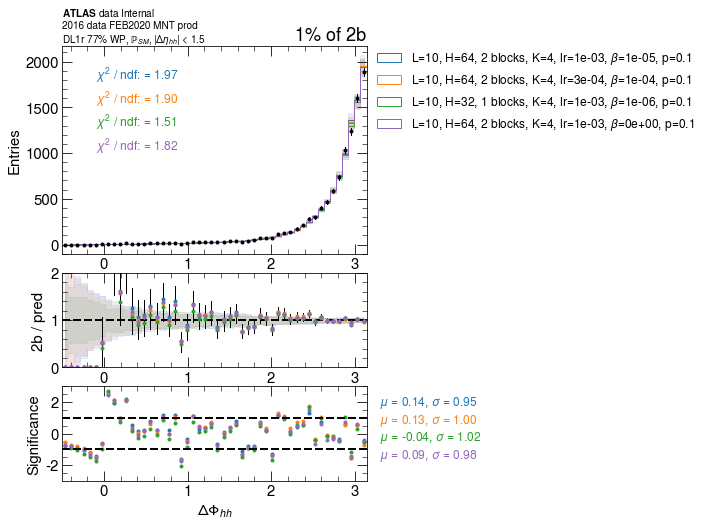

In [69]:
for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9,0.9,0.1,0.1,0.9,0.9,0.5,0.5,0.1],
                              [0.9,0.9,0.4,0.35,0.9,0.9,0.4,0.4,0.9],
                              ['right','right','left','left','right','right','center','center','left'],
                              ['top','top','bottom','bottom','top','top','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    
    n_2b,e = np.histogram(d.df.loc[mask,c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []
    
    for i, color,xi in zip([8,25,28,64],['C0','C1','C2','C4'],[0,.2,.4,.6]):

        nom,std = hists[i][f'{c}_mean'], hists[i][f'{c}_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)
        
        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=xlabels[i])
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')
        
        ls.append(f'$\chi^2$ / ndf: = {chi2[c][i]/bins:.2f}')
        lc.append(color)
        
        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)
        
        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)
        
    
    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)
    
    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)
    
    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)
    
    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12,bbox_to_anchor=(1,1.03))
    
    ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)
    ax1.set_title('1% of 2b',loc='right')
    
    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1.2,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')
    
    plt.savefig(f'{figDir}/best_chi2_overlap_m_hh_cosThetaStar/{c}_SR.pdf',bbox_inches='tight')

Cool, how does this compare to the models that had the best SR loss??

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

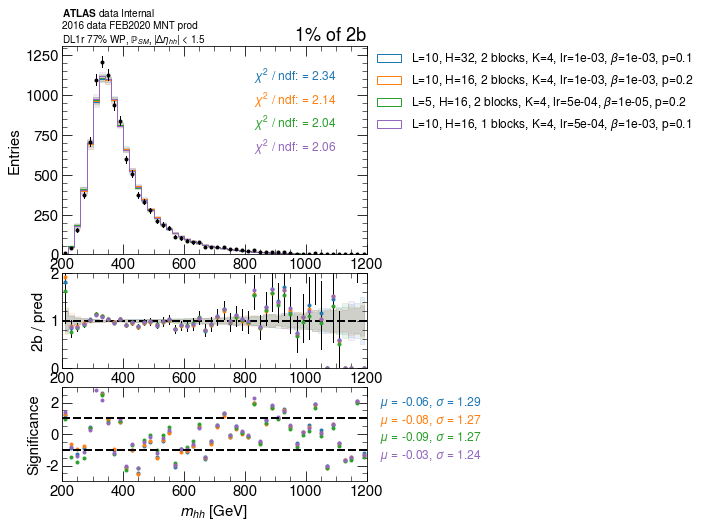

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


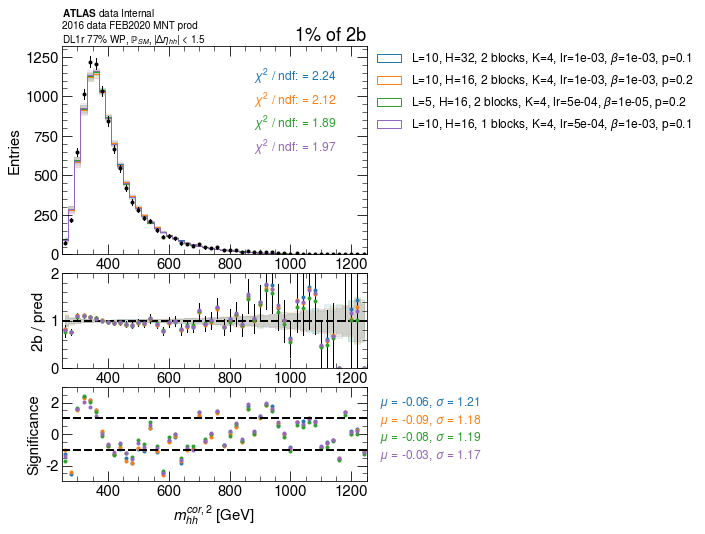

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


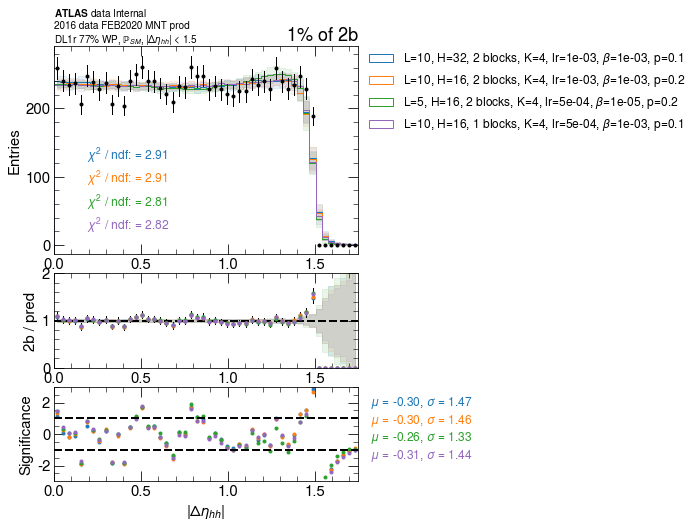

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


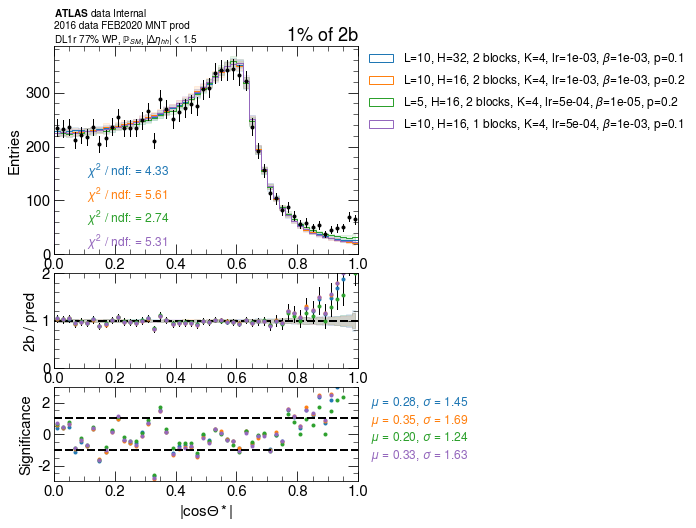

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


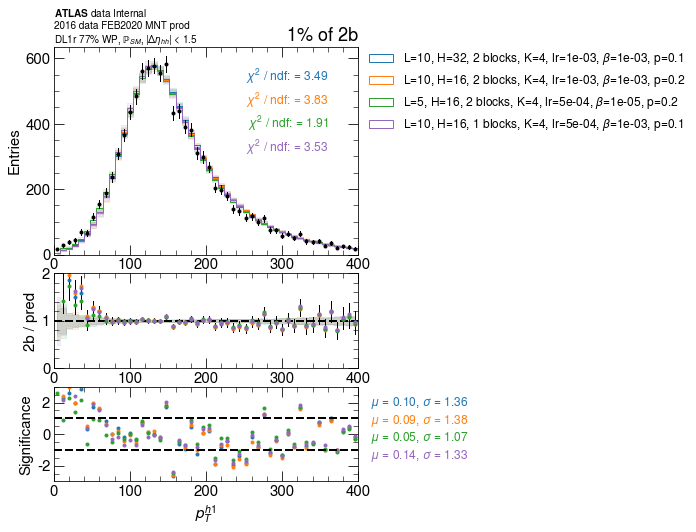

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


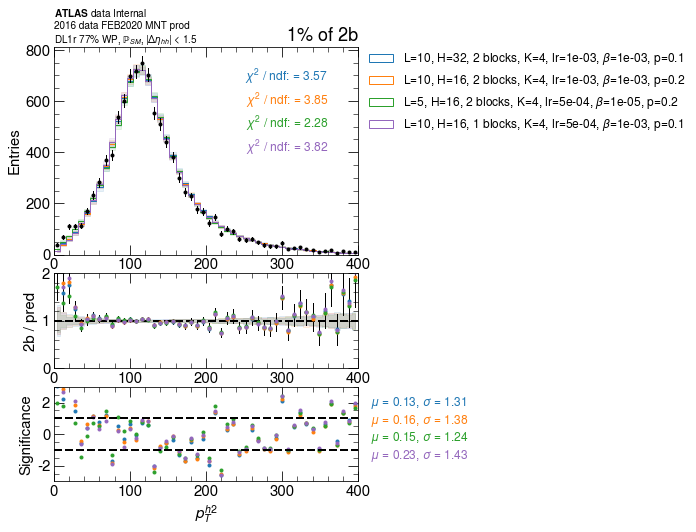

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


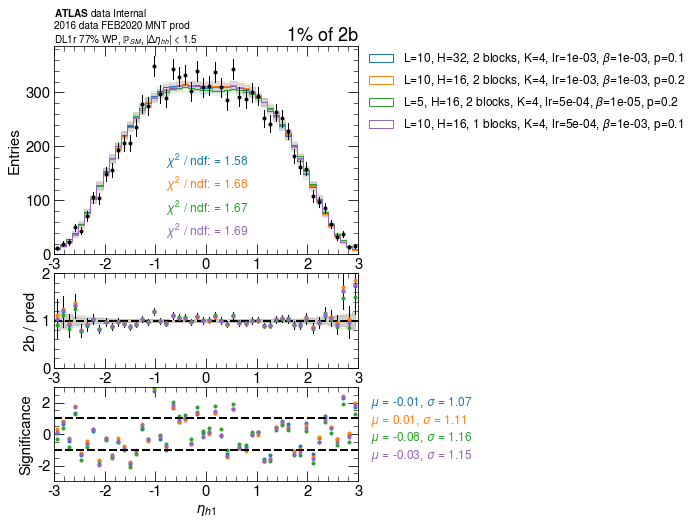

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


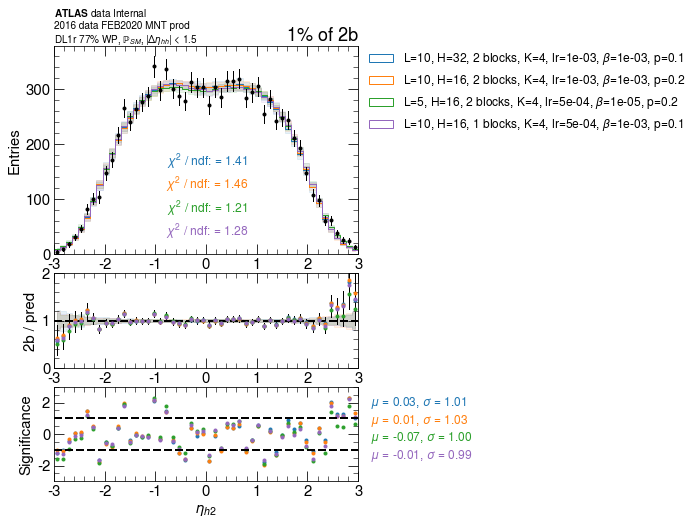

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


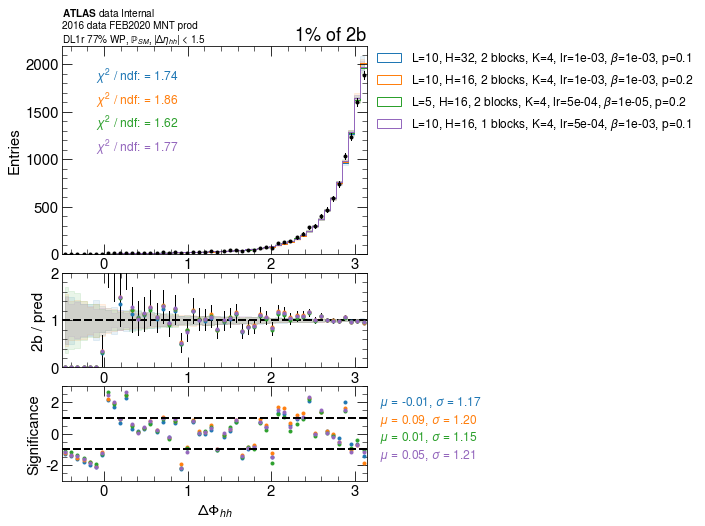

In [70]:
for c,r,xl,wx,wy,ha,va in zip(myVars, myRanges,varLabels,
                              [0.9,0.9,0.1,0.1,0.9,0.9,0.5,0.5,0.1],
                              [0.9,0.9,0.4,0.35,0.9,0.9,0.4,0.4,0.9],
                              ['right','right','left','left','right','right','center','center','left'],
                              ['top','top','bottom','bottom','top','top','bottom','bottom','top']):

    # Make the figure
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(4,2)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    
    n_2b,e = np.histogram(d.df.loc[mask,c],bins,r)
    xx = 0.5 * ( e[1:] + e[:-1] )
    
    # Add text for the chi^2s for these comparisons
    ls,lc = [], []
    zs,zc = [], []
    
    for i, color,xi in zip([22, 42, 24,  9],['C0','C1','C2','C4'],[0,.2,.4,.6]):

        nom,std = hists[i][f'{c}_mean'], hists[i][f'{c}_std']
        
        ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
        ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)
        
        ax1.hist(xx, bins,r,color=color,histtype='step',weights=nom,label=xlabels[i])
        ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')
        
        ls.append(f'$\chi^2$ / ndf: = {chi2[c][i]/bins:.2f}')
        lc.append(color)
        
        z = significance(n_2b,nom,std)
        ax3.plot(xx,z,lw=0,marker='.',color=color)
        
        mu,sigma = np.mean(z),np.std(z)
        zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
        zc.append(color)
        
    
    # Add some curves and lines which only needs to be done once
    ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
    ax2.plot(r,[1]*2,'k--',lw=2)
    
    ax3.plot(r,[1]*2,'k--',lw=2)
    ax3.plot(r,[-1]*2,'k--',lw=2)
    
    # legends
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('2b / pred')
    ax3.set_ylabel('Significance')
    ax3.set_xlabel(xl)
    
    # ranges
    ax1.set_xlim(r)
    ax2.set_ylim(0,2)
    ax3.set_ylim(-3, 3)
    ax1.legend(fontsize=12,bbox_to_anchor=(1,1.03))
    
    ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)
    ax1.set_title('1% of 2b',loc='right')
    
    x = wx*r[1]+ (1-wx)*r[0]
    y = wy*ax1.get_ylim()[1]
    rainbow_text(x,y,ls,lc,yoffset=1.2,ax=ax1,fontsize=12,ha=ha,va=va)
    rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')
    
    plt.savefig(f'{figDir}/best_SR_loss/{c}_SR.pdf',bbox_inches='tight')

In [71]:
len(myVars)

9

**Next:** Let's take a *promising* model and look retrain w/ the MDpT cut!!

(Not sure if I'll do this here, or in another notebook tho.)